# High Dimensional Data Visualization

The first step of any data related task is Exploratory Data Analysis (EDA). Nowadays, almost every dataset you encounter will be consist of a large number of dimensions - making it almost impossible to visualize and comprehend the data in its original dimension.

One approach to tackle this problem is to apply some dimensionality reduction technique, to project the data into a 2D-3D space and visualize the transformed data.

We will demonstrate this approach using three algorithms for dimensionality reduction and visualization of high dimensional data:

   - t-Distributed Stochastic Neighbor Embedding (t-SNE)
   - Uniform Manifold Approximation and Projection ([UMAP](https://github.com/lmcinnes/umap))
   - Principal Component Analysis (PCA)
   
## Reference

1. [McInnes, L, Healy, J, UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction, ArXiv e-prints 1802.03426, 2018](https://arxiv.org/abs/1802.03426)
1. [L.J.P. van der Maaten and G.E. Hinton. Visualizing High-Dimensional Data Using t-SNE. Journal of Machine Learning Research 9(Nov):2579-2605, 2008.](https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf)
   
## Navigation

1. [Data](#Data)
1. [PCA](#PCA)
1. [t-SNE](#t-SNE)
1. [UMAP](#UMAP)
1. [Create Animation](#Create-Animation)

In [1]:
import pandas as pd
import numpy as np
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import get_cmap
from matplotlib.colors import rgb2hex
%matplotlib notebook

## Data

[Top](#Navigation)

We use the "Human Activity Recognition Using Smartphone" [dataset](https://www.kaggle.com/shikhardhwaj/human-activity-recognition-using-smartphone/data). For this exercise, we will only consider the 7352 on 563 train dataset.

In [4]:
data = pd.read_csv("../data/har-train.csv")
print(data.shape)
data.head()

(7352, 563)


tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   
2         -0.967187         -0.978944         -0.996520         -0.963668   
3         -0.983403         -0.990675         -0.997099         -0.982750   
4         -0.980817         -0.990482         -0.998321         -0.979672   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X    ...     \
0         -0.923527         -0.934724    ...      
1         -0.957686         -0.943068    ...      
2         -0.977469         -0.938692    ...      
3         -0.989302         -0.938692    ...      
4         -0.990441         -0.942469    ...      

   fBodyBodyGyroJerkMag-kurtosis()  angle(tBodyAccMean,gravity)  \
0                        -0.710304                    -0.112754   
1                        -0.861499                     0.053477   
2                        -0.760104                    -0.118559   
3                        -0.482845                    -0.036788   
4                        -0.699205                     0.123320   

   angle(tBodyAccJerkMean),gravityMean)  angle(tBodyGyroMean,gravityMean)  \
0                              0.030400                         -0.464761   
1                             -0.007435                         -0.732626   
2                              0.177899                          0.100699   
3                             -0.012892                          0.640011   
4                              0.122542                          0.693578   

   angle(tBodyGyroJerkMean,gravityMean)  angle(X,gravityMean)  \
0                             -0.018446             -0.841247   
1                              0.703511             -0.844788   
2                              0.808529             -0.848933   
3                             -0.485366             -0.848649   
4                             -0.615971             -0.847865   

   angle(Y,gravityMean)  angle(Z,gravityMean)  subject  Activity  
0              0.179941             -0.058627        1  STANDING  
1              0.180289             -0.054317        1  STANDING  
2              0.180637             -0.049118        1  STANDING  
3              0.181935             -0.047663        1  STANDING  
4              0.185151             -0.043892        1  STANDING  

[5 rows x 563 columns]

In [5]:
X = data.loc[:, ~data.columns.isin(['subject', 'Activity'])].copy()
y = data.Activity.copy()
del data

## PCA

[Top](#Navigation)

In [6]:
n_components = 3
pca = PCA(n_components = n_components)
pca_data = pd.DataFrame(pca.fit_transform(X), 
                        columns=['pca_%d' % (i+1) for i in range(n_components)])

<IPython.core.display.Javascript object>


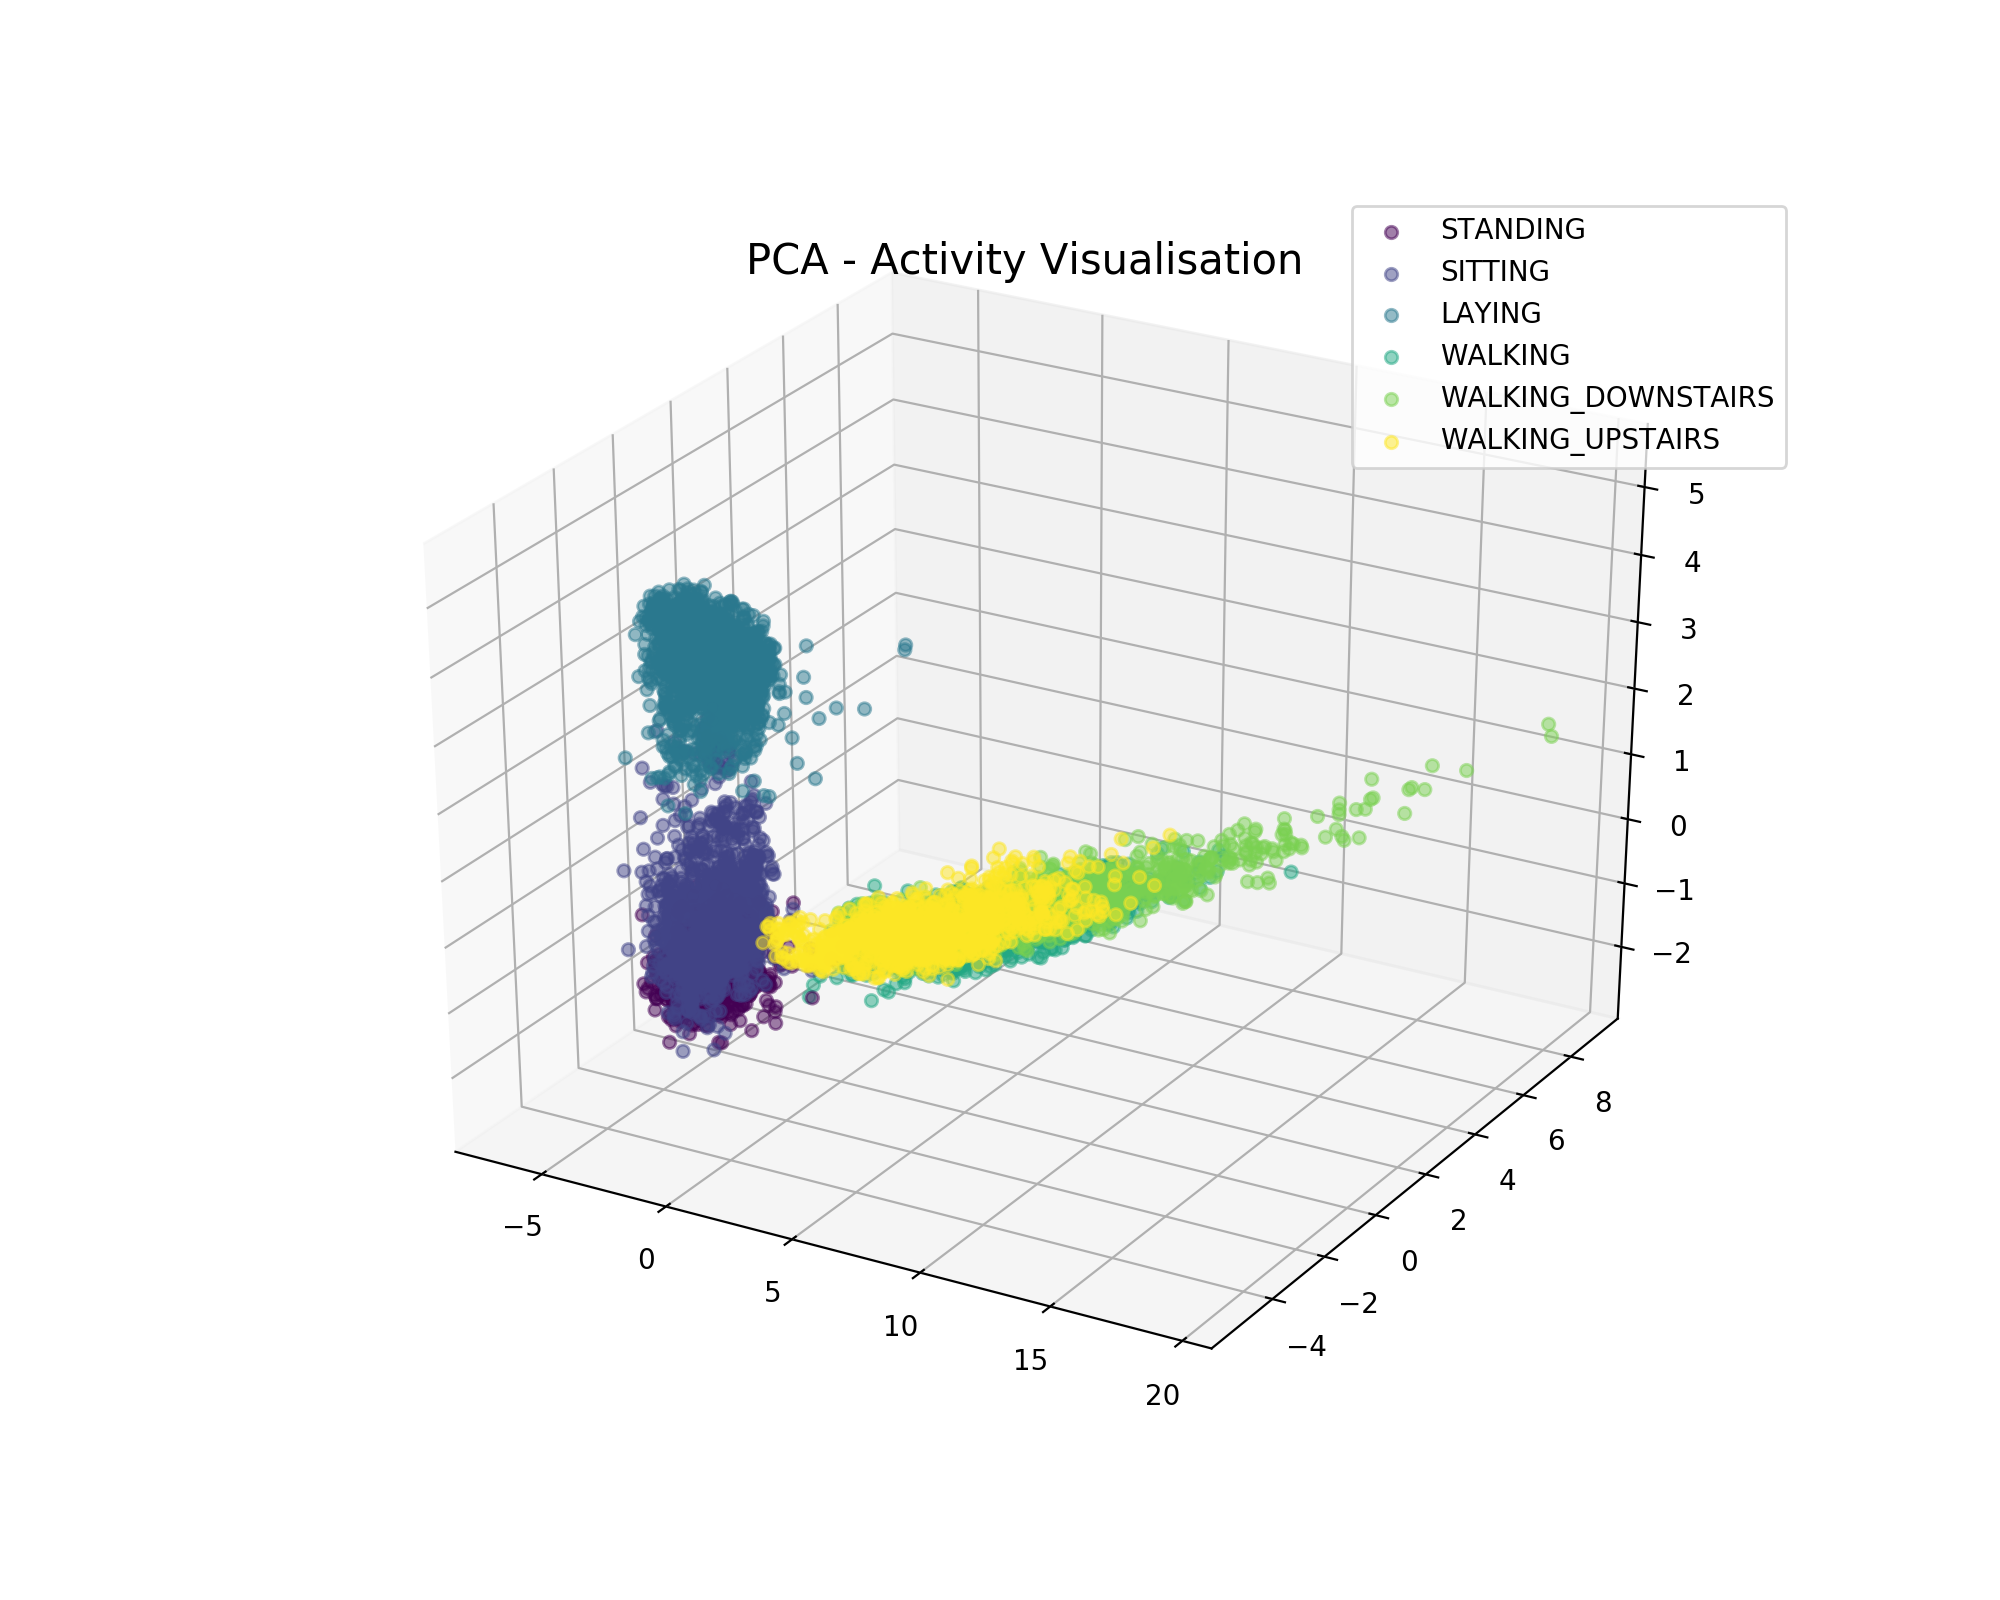

In [7]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

n, uniq = y.nunique(), y.unique()
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.linspace(0,1,n)]

for i, group in enumerate(uniq):
    cond = (y == group).values
    curr_data = pca_data[cond].copy()
    ax.scatter(curr_data['pca_1'], # x-axis
               curr_data['pca_2'], # y-axis
               curr_data['pca_3'], # z-axis
               c=colors[i],
               alpha=0.5, 
               label=group
              )
    
ax.set_title('PCA - Activity Visualisation', {'fontsize':15})
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
#ax.view_init(30, 10)

## t-SNE

[Top](#Navigation)

We first apply t-SNE on the original data. This might take a while to run:

“Since t-SNE scales quadratically in the number of objects N, its applicability is limited to data sets with only a few thousand input objects; beyond that, learning becomes too slow to be practical (and the memory requirements become too large)”.

In [66]:
seed = 123
perplexity = 40
n_components = 3

tsne = TSNE(n_components=n_components, random_state=seed, perplexity=perplexity)
tsne_data = pd.DataFrame(tsne.fit_transform(X), 
                        columns = ['tsne_%d' % (i+1) for i in range(n_components)])

<IPython.core.display.Javascript object>


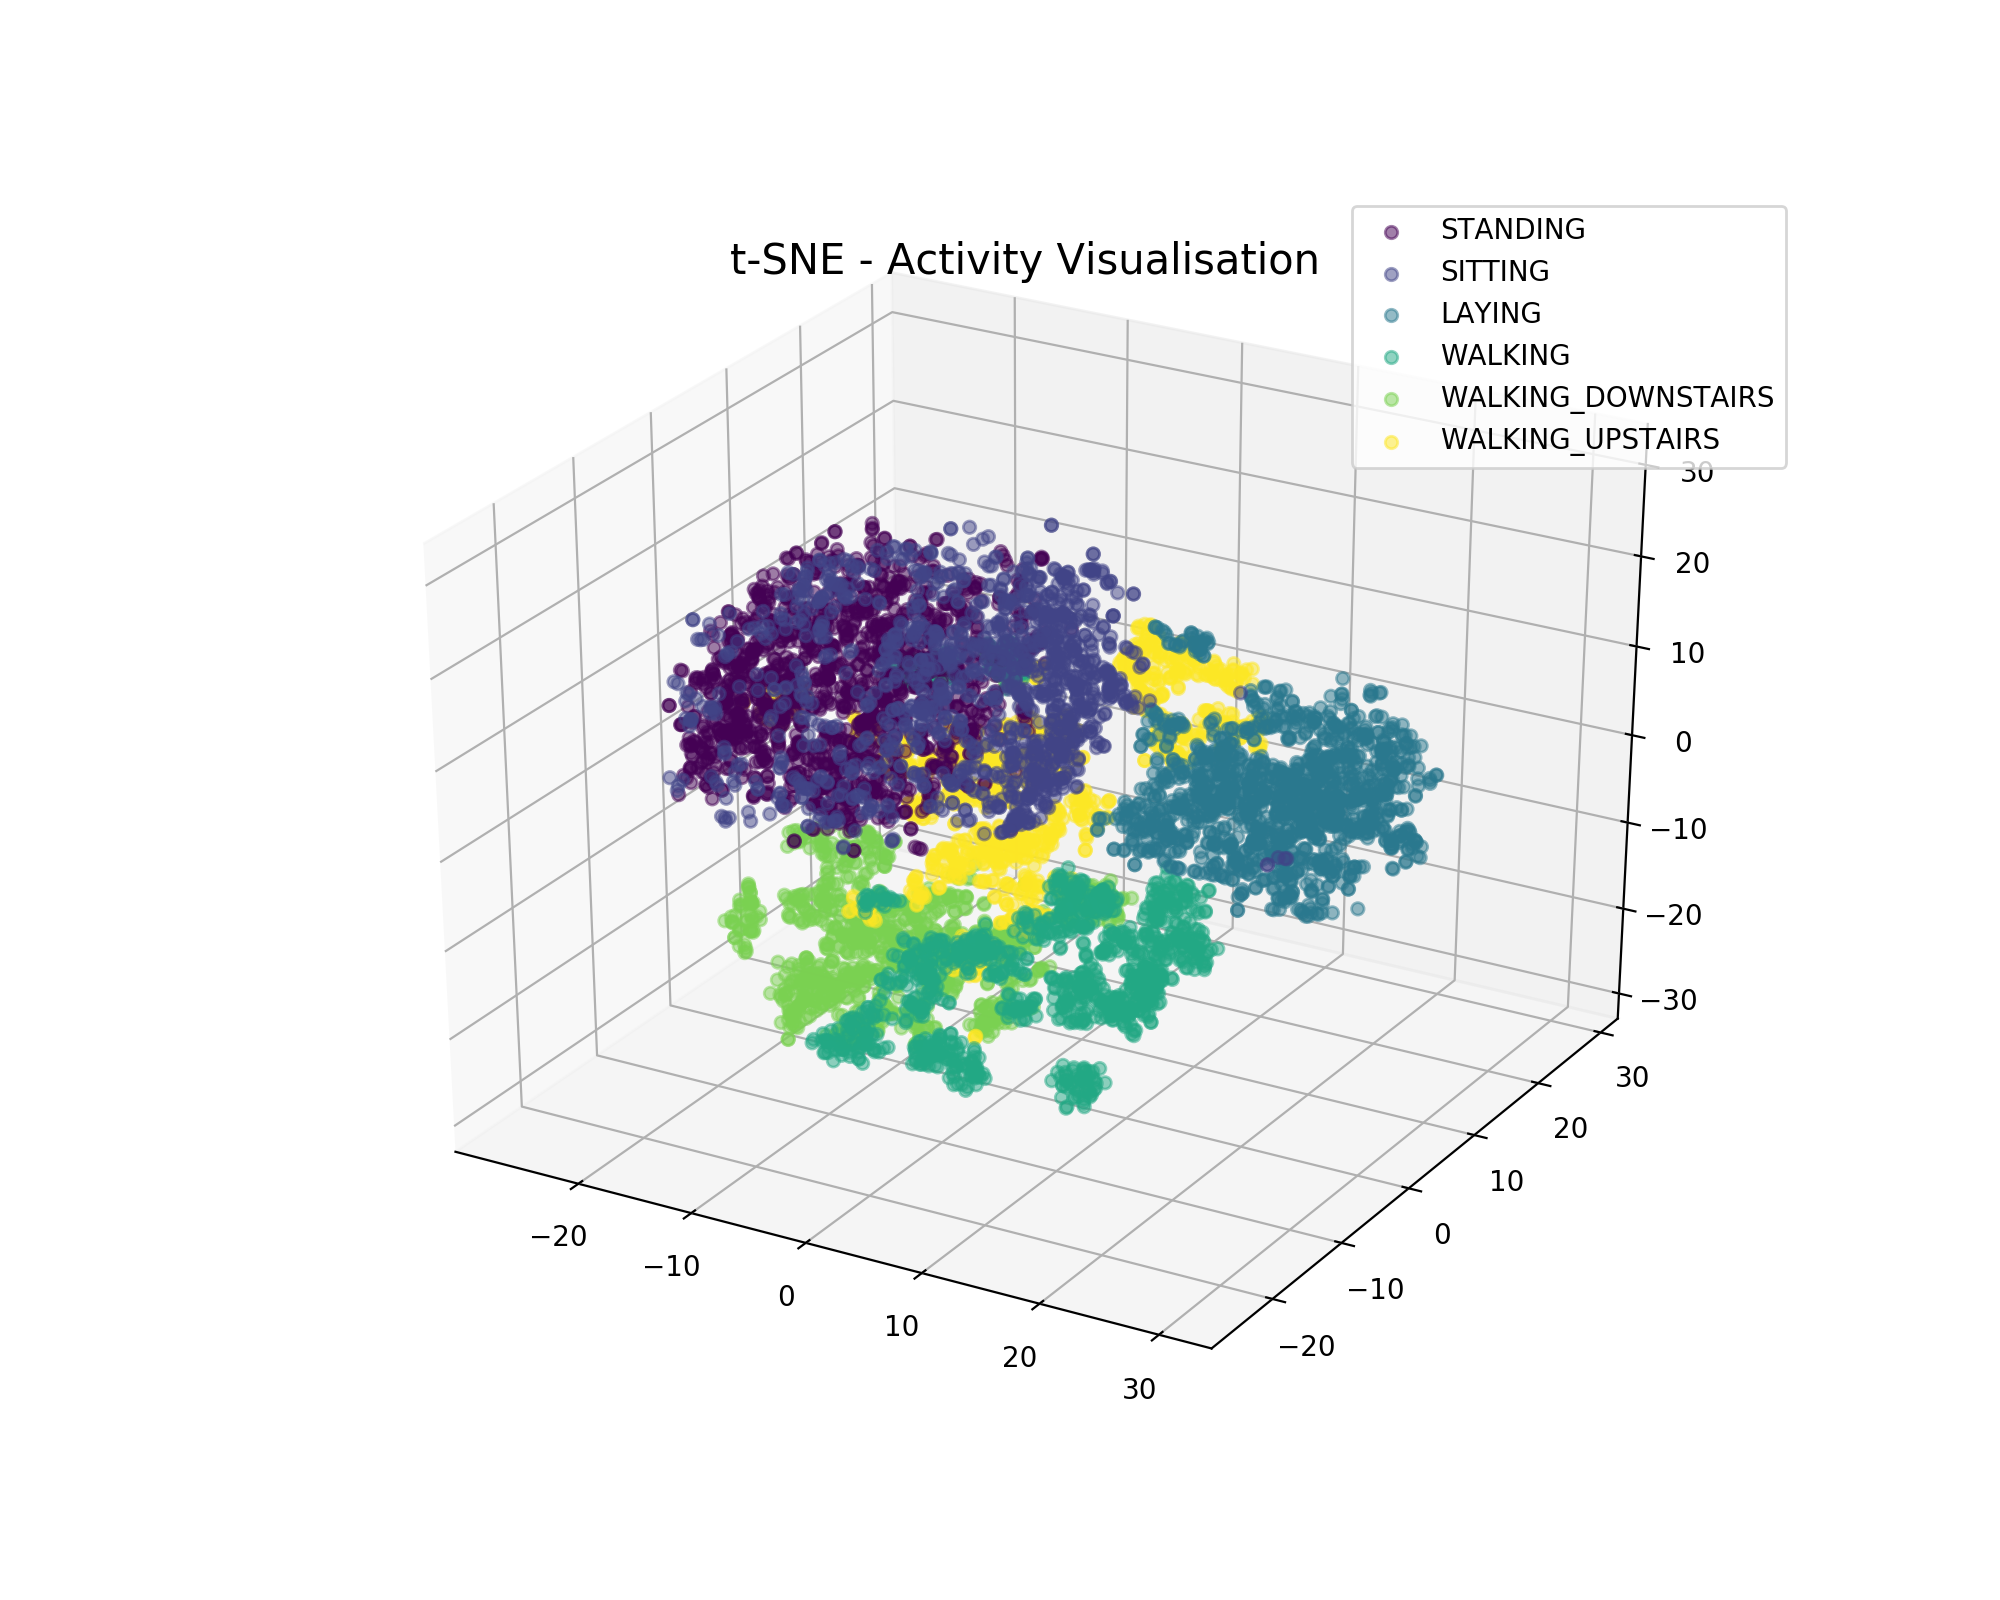

In [67]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i, group in enumerate(uniq):
    cond = (y == group).values
    curr_data = tsne_data[cond].copy()
    ax.scatter(curr_data['tsne_1'], # x-axis
               curr_data['tsne_2'], # y-axis
               curr_data['tsne_3'], # z-axis
               c=colors[i],
               alpha=0.5, 
               label=group
              )
    
ax.set_title('t-SNE - Activity Visualisation', {'fontsize':15})
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

## PCA + t-SNE

[Top](#Navigation)

We now use PCA as a prior step to the t-SNE.

In [68]:
pca = PCA(n_components=50)
pca_X = pca.fit_transform(X)

seed = 123
perplexity = 40
n_components = 3

tsne = TSNE(n_components=n_components, random_state=seed, perplexity=perplexity)
tsne_data = pd.DataFrame(tsne.fit_transform(pca_X), 
                        columns = ['tsne_%d' % (i+1) for i in range(n_components)])

<IPython.core.display.Javascript object>


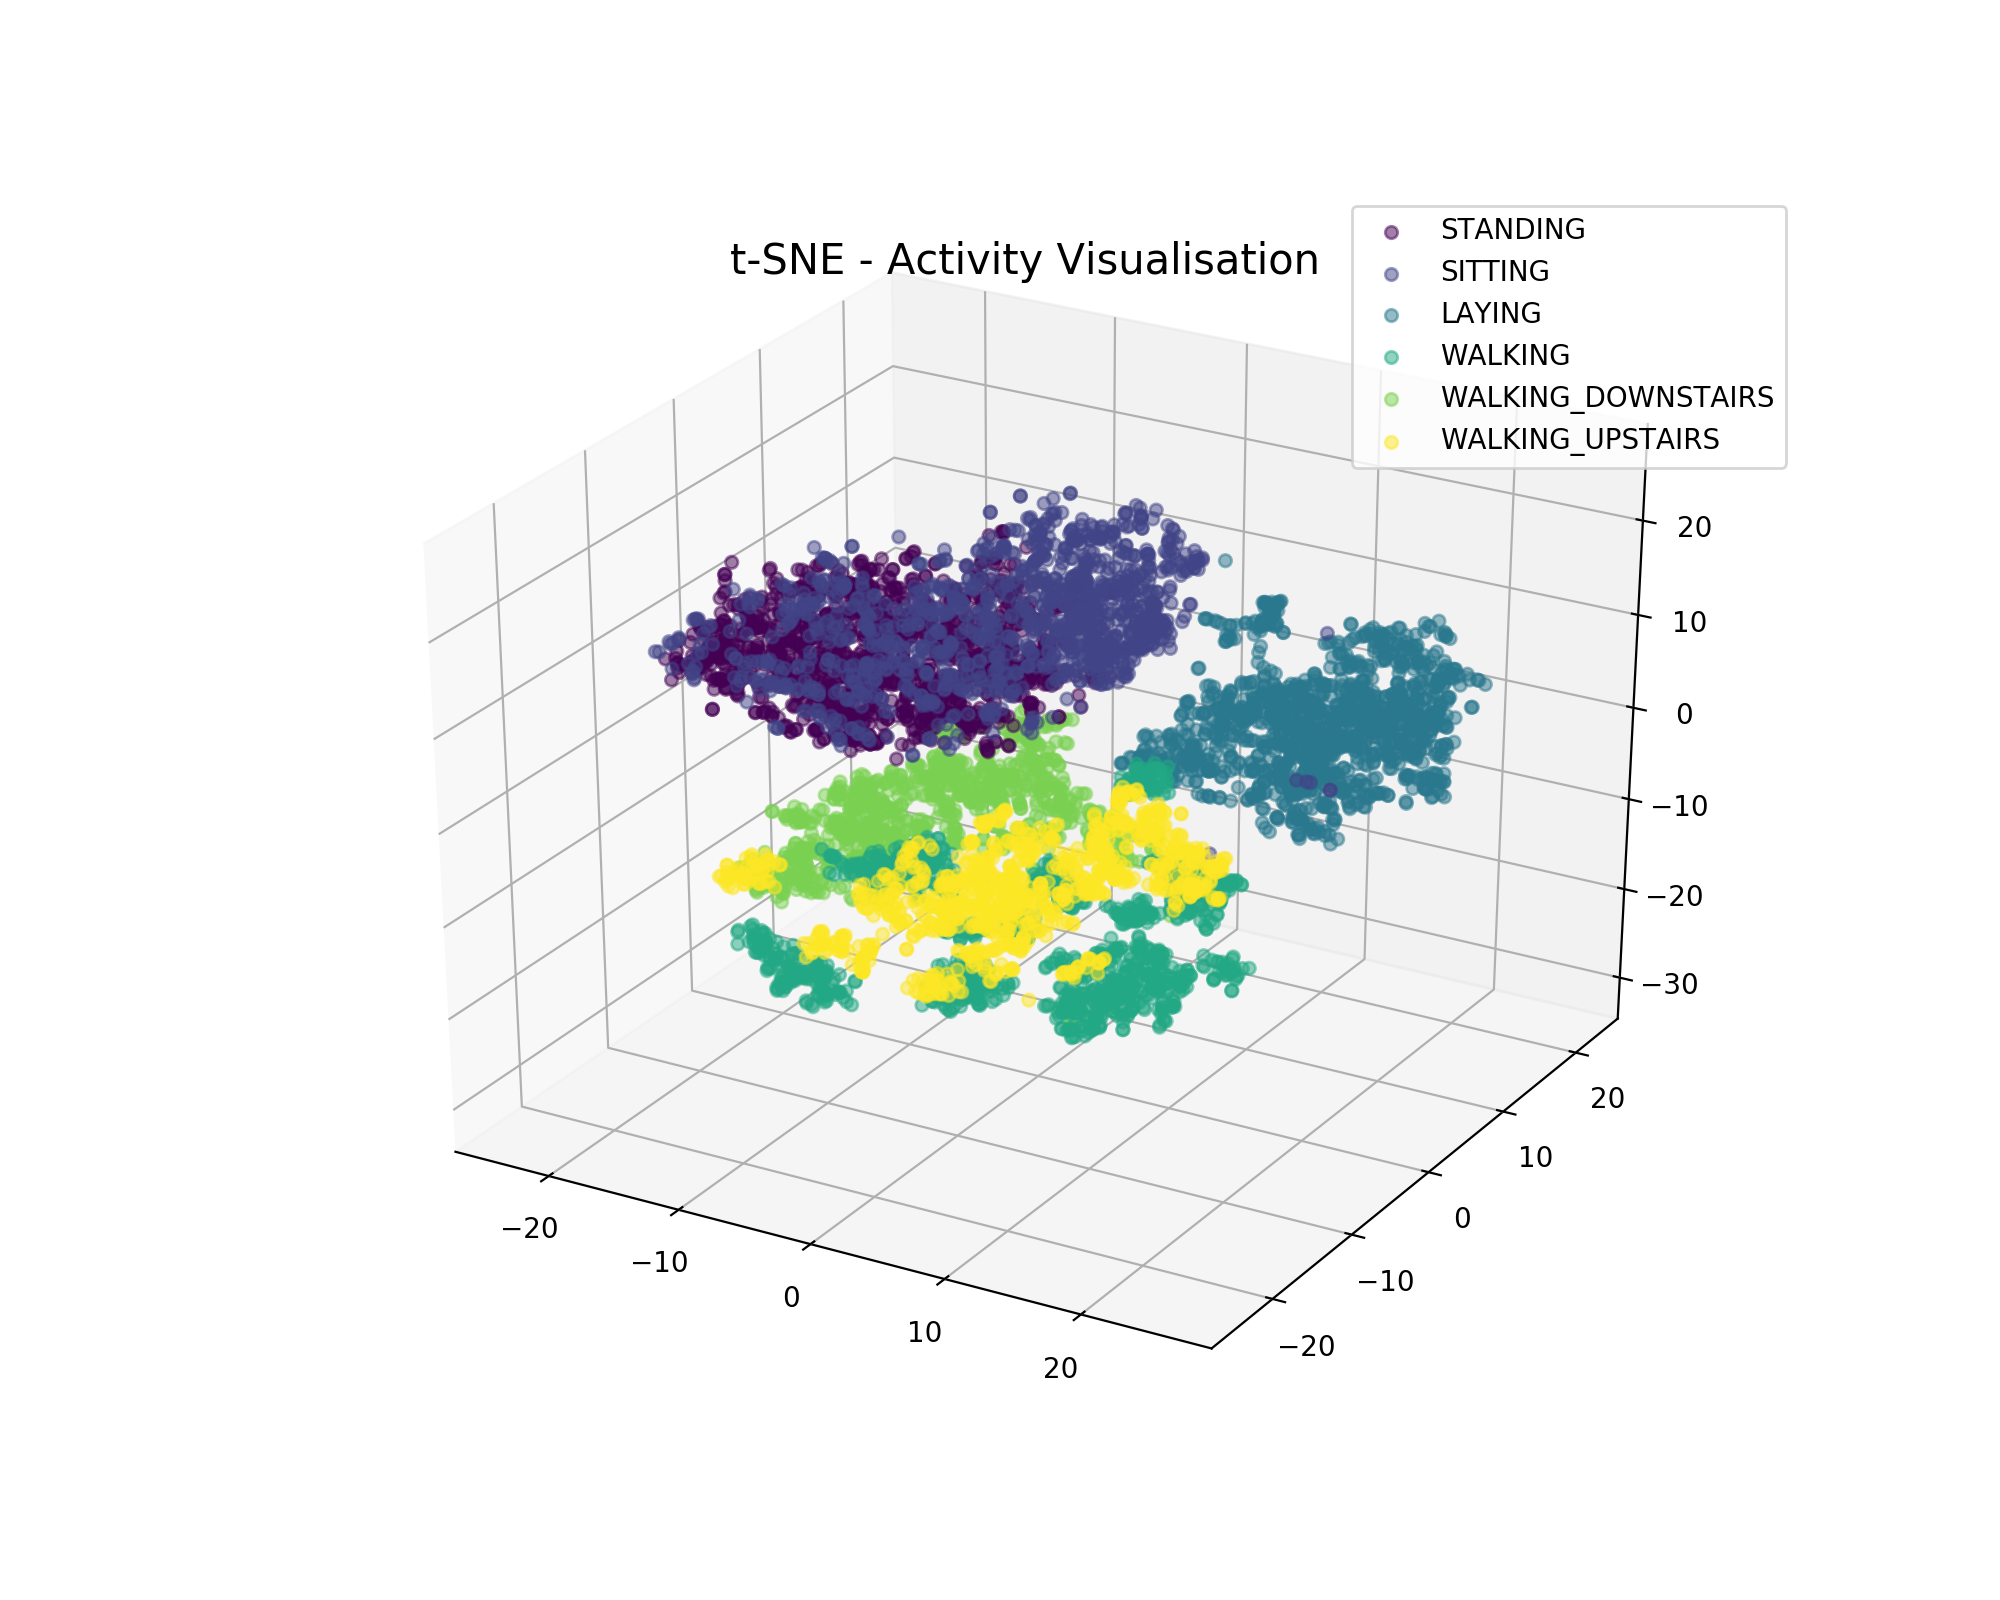

In [69]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i, group in enumerate(uniq):
    cond = (y == group).values
    curr_data = tsne_data[cond].copy()
    ax.scatter(curr_data['tsne_1'], # x-axis
               curr_data['tsne_2'], # y-axis
               curr_data['tsne_3'], # z-axis
               c=colors[i],
               alpha=0.5, 
               label=group
              )
    
ax.set_title('t-SNE - Activity Visualisation', {'fontsize':15})
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

## UMAP

[Top](#Navigation)

In [8]:
seed = 1
n_neighbors = 50
learning_rate = .9
min_dist = 1.
n_components = 3
embedding = UMAP(n_neighbors=n_neighbors,
                 learning_rate=learning_rate,
                 n_components=n_components,
                 init="random",
                 min_dist=min_dist,
                 random_state = seed)\
                .fit_transform(X)

In [9]:
umap_data = pd.DataFrame(embedding, 
                         columns = ['umap_%d' % (i+1) for i in range(n_components)])

<IPython.core.display.Javascript object>


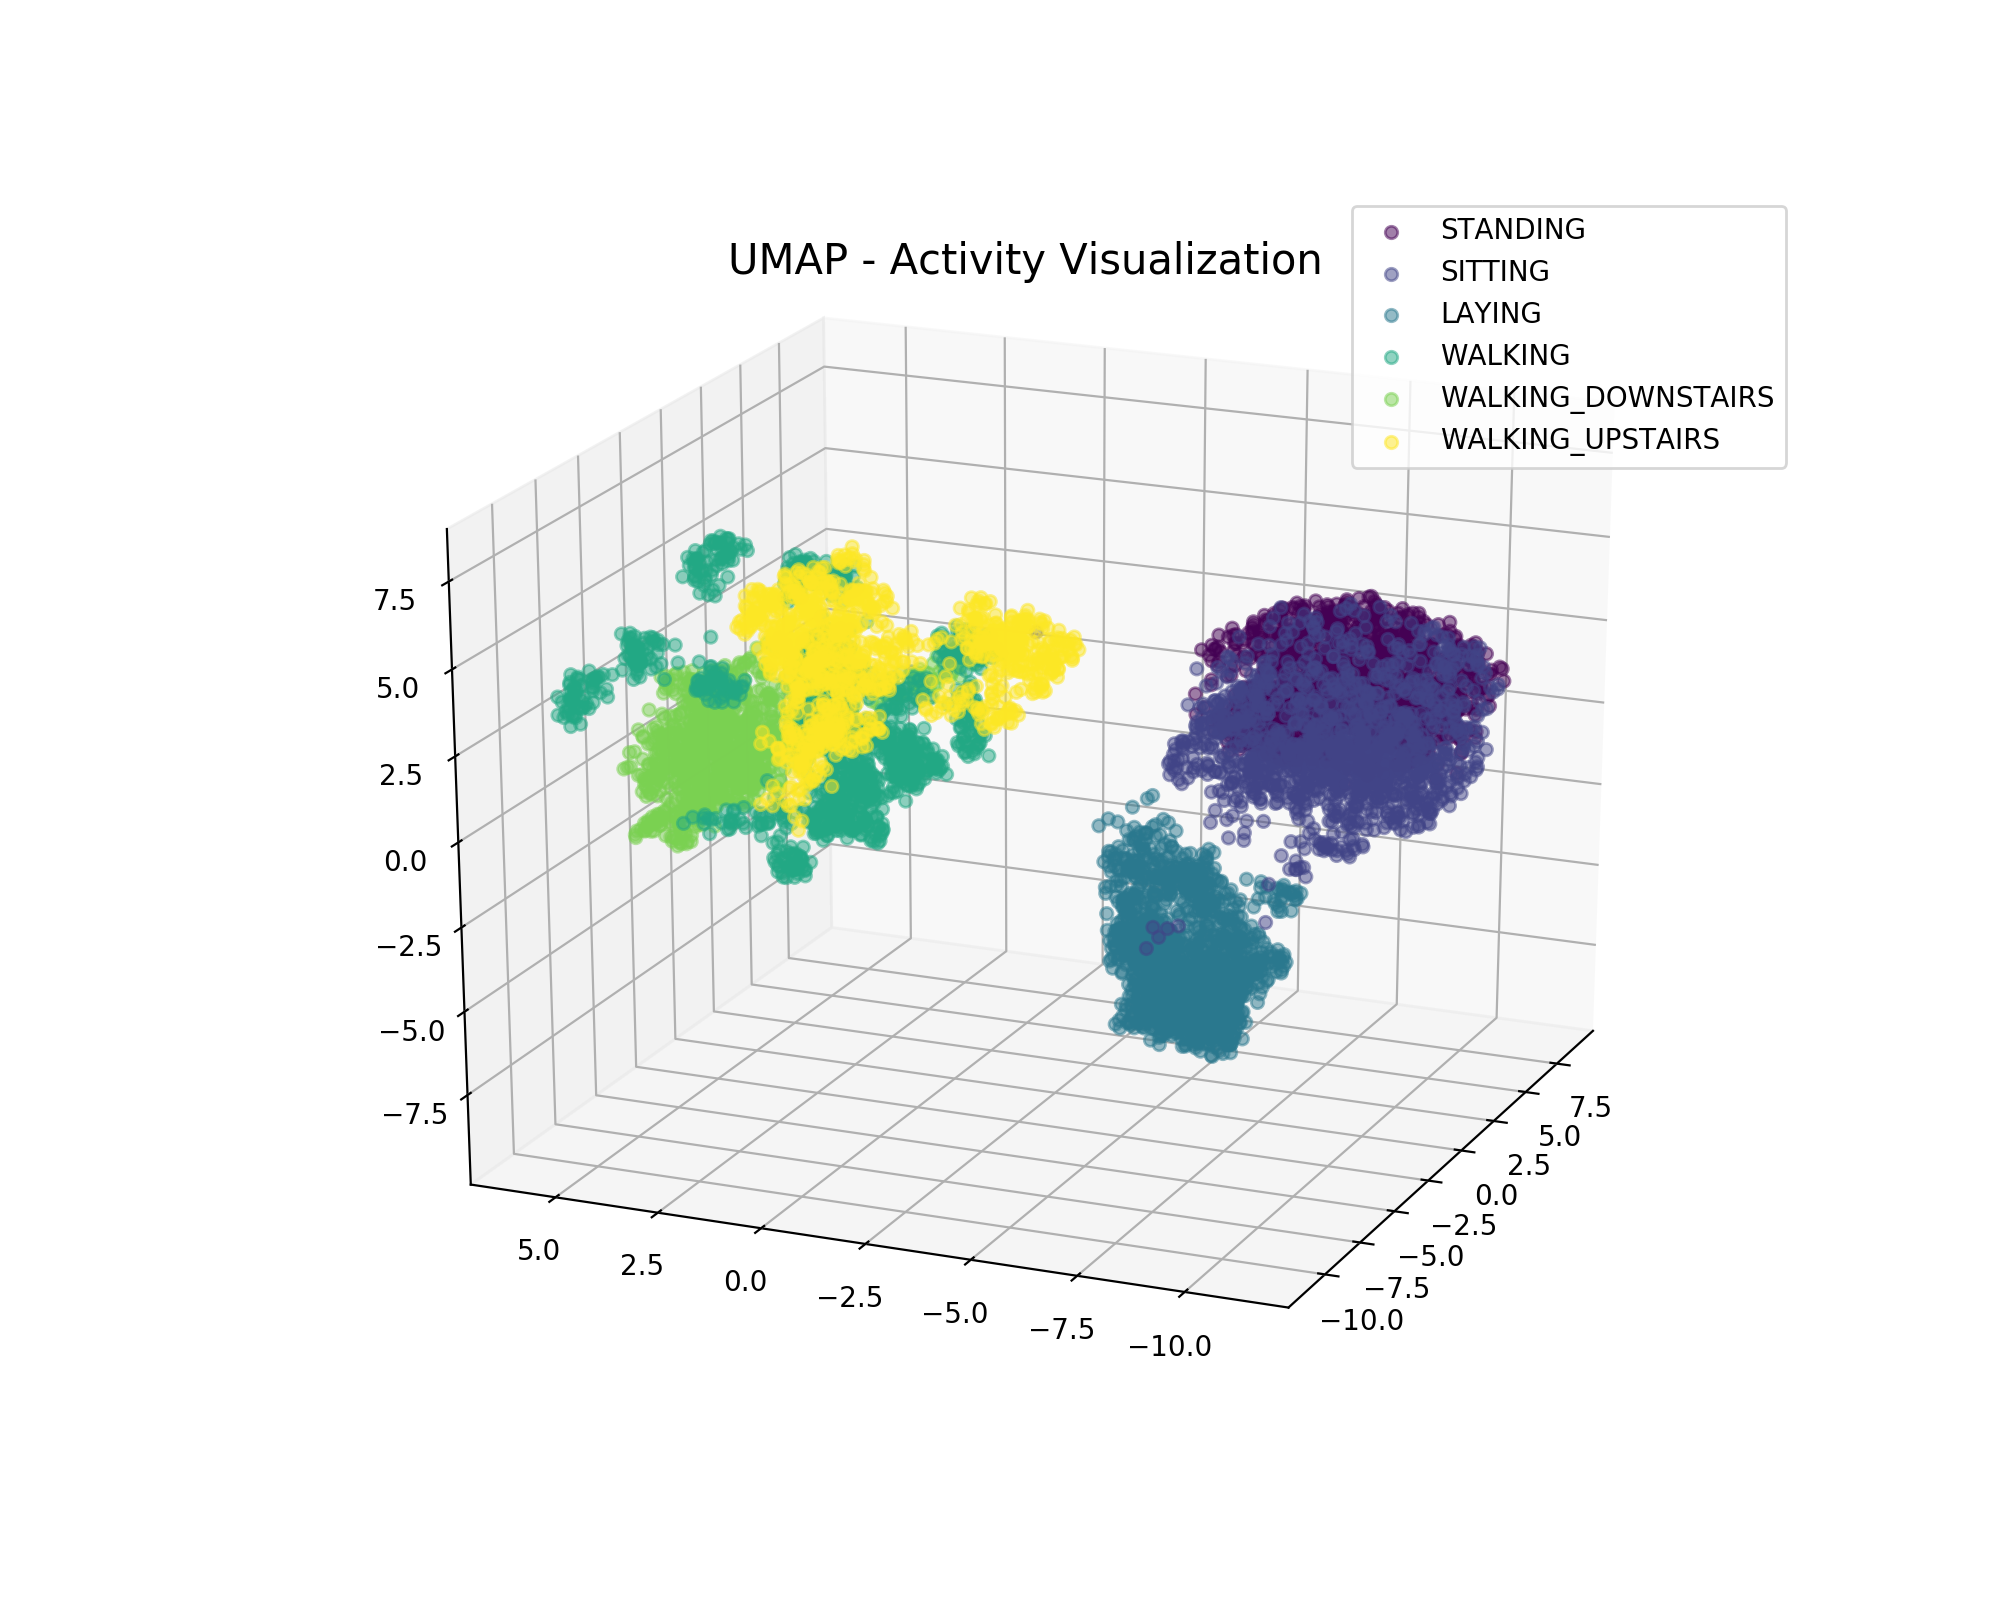

In [10]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i, group in enumerate(uniq):
    cond = (y == group).values
    curr_data = umap_data[cond].copy()
    ax.scatter(curr_data['umap_1'], # x-axis
               curr_data['umap_2'], # y-axis
               curr_data['umap_3'], # z-axis
               c=colors[i],
               alpha=0.5, 
               label=group
              )
    
ax.set_title('UMAP - Activity Visualization', {'fontsize':15})
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

## Create Animation

[Top](#Navigation)

In [15]:
import imageio
from matplotlib.animation import FuncAnimation

<IPython.core.display.Javascript object>


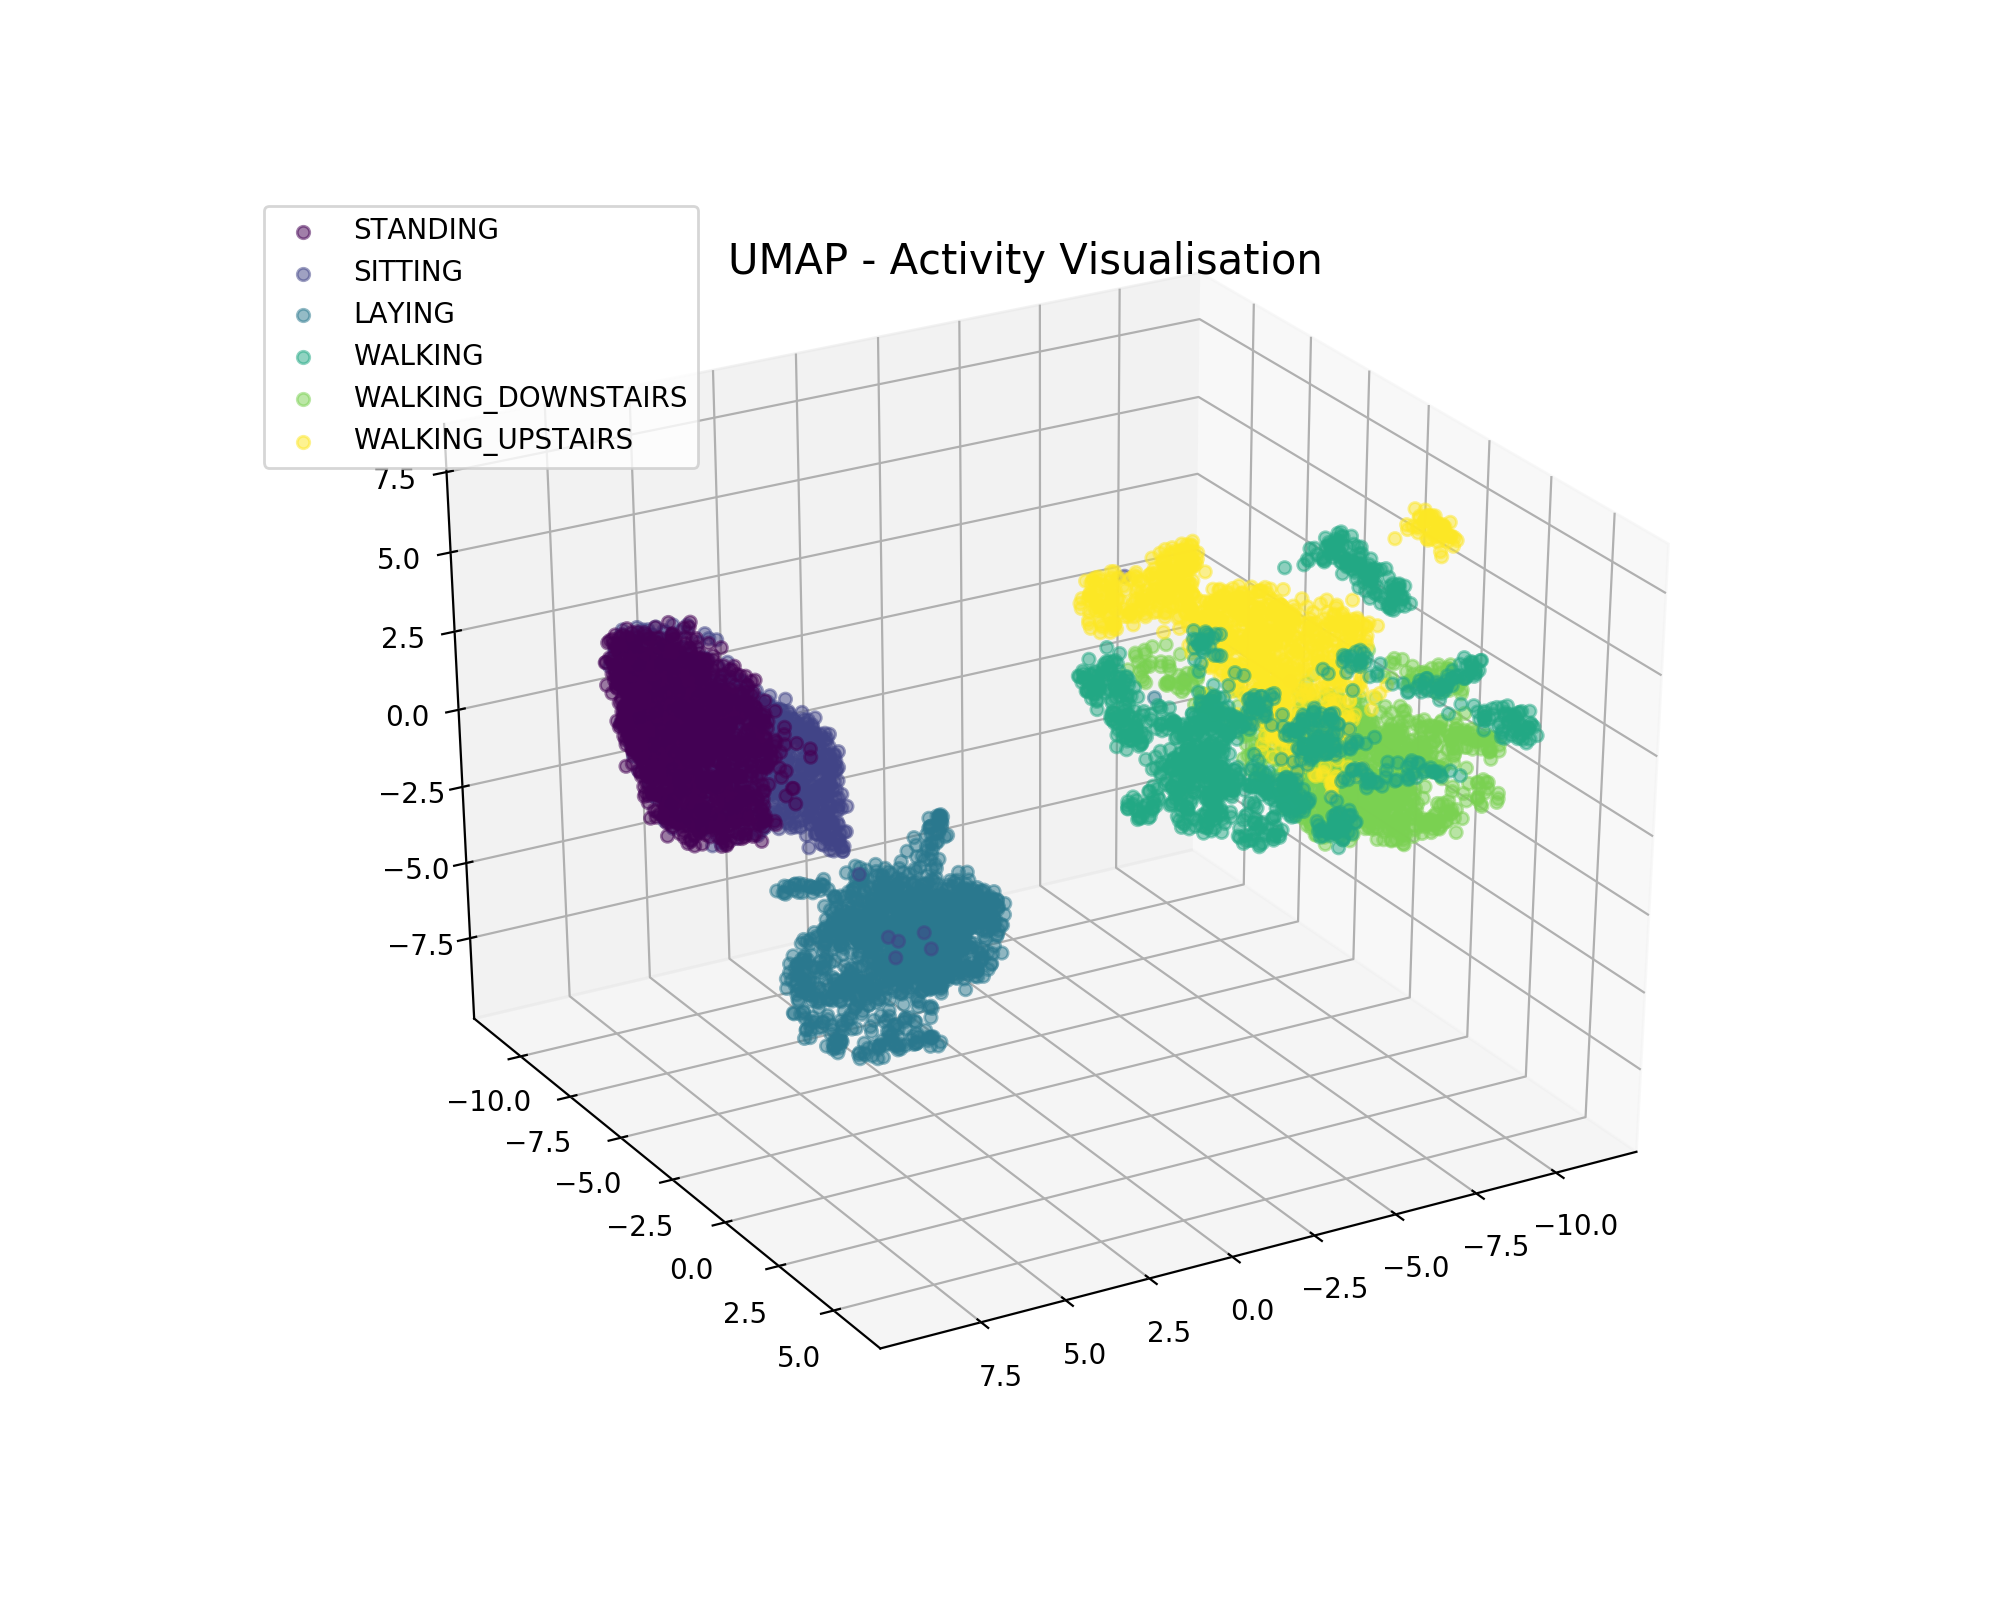

In [29]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i, group in enumerate(uniq):
    cond = (y == group).values
    curr_data = umap_data[cond].copy()
    ax.scatter(curr_data['umap_1'], # x-axis
               curr_data['umap_2'], # y-axis
               curr_data['umap_3'], # z-axis
               c=colors[i],
               alpha=0.5, 
               label=group
              )
    
ax.set_title('UMAP - Activity Visualisation', {'fontsize':15})
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc = 'upper left')

def update(i):
    ax.view_init(30, i)
    return ax

if __name__ == '__main__':
    anim = FuncAnimation(fig, update, 
                         frames = np.arange(0, 360, 20), 
                         interval = 200)
    anim.save('umap.gif', dpi=80, writer='imagemagick')